<a href="https://colab.research.google.com/github/michaeldlee23/cs390-project/blob/genetic-algorithm-tests/mnist-classifier/genetic_algorithm_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Statements

In [4]:
import os, random, time, imageio
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam 
from PIL import Image
from matpotlib import style
import matplotlib.pyplot as plt

style.use('dark_background')

## Constants and Configuration

In [6]:
random.seed(1337)
tf.random.set_seed(1337)

IH, IW, IZ = 28, 28, 1
IMAGE_SIZE = IH * IW * IZ
NUM_CLASSES = 10

NUM_GENERATIONS = 25
POPULATION_SIZE = 20
SELECTION_SIZE = 5
MUTATION_RATE = 0.1
MUTATION_WEIGHT_RANGE = (-0.8, 0.8)
MUTATION_BIAS_RANGE = (-0.1, 0.1)

currentPopulation = list()

# Logging
VERBOSE = True
# VERBOSE = False
generationFitness = list()      # average fitness per generation
topGenerationFitness = list()   # average fitness of top SELECTION_SIZE individuals
                                # from each generation
DRIVE_PREFIX = '/content/drive/My Drive/Colab Notebooks/genetic-algorithm-mnist/'


## Genetic Algorithm

In [7]:
def evaluatePopulation(population, data):
  ((xTrain, yTrain), (xTest, yTest)) = data
  fitness = list()
  for i in range(len(population)):
    individual = population[i]
    predictions = predict(xTrain, individual)
    accuracy = evalResults(data[0], predictions)
    fitness.append(accuracy)
    if VERBOSE:
      print('individual %2d accuracy: %f%%' % (i + 1, accuracy * 100))
  print('Average accuracy of generation: %f%%' % (np.mean(fitness) * 100))
  return fitness


def crossover(parents, method='uniform'):
  print('Performing %s crossover...' % method)
  newPopulation = list()

  # Parents get to survive to next generation
  newPopulation += parents
  
  for i in range(SELECTION_SIZE, POPULATION_SIZE):
    # Select parents for new individual
    parentA, parentB = random.sample(parents, 2)

    # Construct new individual
    # Note that for this network, weights are [n x m] matrix
    # and biases are a list of size m
    individual = buildModel()
    for j in range(len(parentA.layers)):
      parentWeights = (parentA.layers[j].get_weights()[0],
                       parentB.layers[j].get_weights()[0])
      parentBiases = (parentA.layers[j].get_weights()[1],
                      parentB.layers[j].get_weights()[1])
      if method.lower() == 'uniform':
        weights, biases = uniformCrossover(parentWeights, parentBiases)
      elif method.lower() == 'spc' or 'single' in method.lower():
        weights, biases = singlePointCrossover(parentWeights, parentBiases)
      else:
        raise(ValueError('Unknown crossover method %s' % method))
        return None
      individual.layers[j].set_weights([weights, biases])
    newPopulation.append(individual)
  return newPopulation


def uniformCrossover(parentWeights, parentBiases):
  weights = np.zeros(parentWeights[0].shape)
  for r in range(weights.shape[0]):
    for c in range(weights.shape[1]):
      weights[r][c] = (parentWeights[0][r][c] if random.random() < 0.5 else
                       parentWeights[1][r][c])
      # Add random mutations
      if (random.random() < MUTATION_RATE):
        weights[r][c] = random.uniform(*MUTATION_WEIGHT_RANGE)
  biases = np.zeros(parentBiases[0].shape)
  for k in range(biases.shape[0]):
    biases[k] = (parentBiases[0][k] if random.random() < 0.5 else
                 parentBiases[1][k])
    # Add random mutations
    if (random.random() < MUTATION_RATE):
      biases[k] = random.uniform(*MUTATION_BIAS_RANGE)
  return (weights, biases)


def singlePointCrossover(parentWeights, parentBiases):
  weights = np.zeros(parentWeights[0].shape)
  weightPartition = random.randint(0, parentWeights[0].shape[0] * parentWeights[0].shape[1])
  i = 0
  for r in range(weights.shape[0]):
    for c in range(weights.shape[1]):
      if i < weightPartition:
        weights[r][c] = parentWeights[0][r][c]
      else:
        weights[r][c] = parentWeights[1][r][c]
      # Add random mutations
      if (random.random() < MUTATION_RATE):
        weights[r][c] = random.uniform(*MUTATION_WEIGHT_RANGE)
      i += 1
  biases = np.zeros(parentBiases[0].shape)
  biasPartition = weightPartition // weights.shape[0]
  for k in range(biases.shape[0]):
    if k < biasPartition:
      biases[k] = parentBiases[0][k]
    else:
      biases[k] = parentBiases[1][k]
    if (random.random() < MUTATION_RATE):
      biases[k] = random.uniform(*MUTATION_BIAS_RANGE)
  return (weights, biases)


def evolve(population, fitness):
  # Order the population in order of fitness
  # Note that fitness is measured by accuracy, so we sort in descending order
  sortedIndexes = sorted(range(len(fitness)), key=lambda x: -fitness[x])
  sortedPopulation = [population[i] for i in sortedIndexes]

  print('Selected individuals: %s' % [i + 1 for i in sortedIndexes[:SELECTION_SIZE]])
  newPopulation = crossover(sortedPopulation[:SELECTION_SIZE],
                            method='uniform')
  return newPopulation


## Pipeline Functions

In [11]:
def clearOldData():
  # Clear previous runs
  global currentPopulation, generationFitness, topGenerationFitness
  currentPopulation = list()
  generationFitness = list()
  topGenerationFitness = list()


def getRawData():
  (xTrain, yTrain), (xTest, yTest) = tf.keras.datasets.mnist.load_data()
  return ((xTrain, yTrain), (xTest, yTest))


def preprocessData(raw):
  ((xTrain, yTrain), (xTest, yTest)) = raw
  xTrain, xTest = xTrain / 255.0, xTest / 255.0
  xTrainP = xTrain.reshape((np.shape(xTrain)[0], -1))
  xTestP = xTest.reshape((np.shape(xTest)[0], -1))
  yTrainP = to_categorical(yTrain, NUM_CLASSES)
  yTestP = to_categorical(yTest, NUM_CLASSES)
  return ((xTrainP, yTrainP), (xTestP, yTestP))


def buildModel():
  model = Sequential()

  model.add(Dense(IMAGE_SIZE, input_shape=(IMAGE_SIZE, )))
  # model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(NUM_CLASSES, activation='softmax'))

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model


def predict(input, individual):
  prediction = individual.predict(input, 0)
  oneHot = np.zeros_like(prediction)
  oneHot[np.arange(len(prediction)), prediction.argmax(1)] = 1
  return oneHot


def getFittestIndividual(data):
  global currentPopulation
  for i in range(POPULATION_SIZE):
    currentPopulation.append(buildModel())

  fitness = None
  for generation in range(NUM_GENERATIONS):
    start = time.time()
    print('----------GENERATION %s----------' % (generation + 1))
    fitness = evaluatePopulation(currentPopulation, data)

    currentPopulation = evolve(currentPopulation, fitness)
    end = time.time()
    print('Generation produced in %ds' % (end - start))
    logFitness(sorted(fitness, reverse=True))


  # Order the last population in order of fitness
  sortedIndexes = sorted(range(len(fitness)), key=lambda x: -fitness[x])
  sortedPopulation = [currentPopulation[i] for i in sortedIndexes]
  return currentPopulation[0]


def evalResults(data, predictions):
  _, output = data
  acc = 0
  for i in range(predictions.shape[0]):
    predictedValue = np.argmax(predictions[i])
    actualValue = np.argmax(output[i])
    if np.array_equal(predictions[i], output[i]):  acc += 1
  accuracy = acc / predictions.shape[0]
  return accuracy
  

## Logging Functions

In [12]:
def logFitness(fitness):
  global generationFitness, topGenerationFitness
  generationFitness.append(np.mean(fitness) * 100)
  topGenerationFitness.append(np.mean(fitness[:SELECTION_SIZE]) * 100)
  

def graphFitness():
  df = pd.DataFrame({'generation': [i + 1 for i in range(NUM_GENERATIONS)],
                     'fitness': generationFitness,
                     'top': topGenerationFitness})
  OUTPUT_PATH = DRIVE_PREFIX + 'logs/learning-curve.png'
  plt.figure(figsize=(10, 10))
  plt.plot('generation', 'fitness', data=df, color='red',
           label='Population')
  plt.plot('generation', 'top', data=df, color='blue',
           label='Top %s Individuals' % SELECTION_SIZE)
  plt.grid()
  plt.xlabel('Generation')
  plt.ylabel('Average Accuracy')
  plt.title('Average Accuracy Over Time')
  plt.legend()
  plt.savefig(OUTPUT_PATH)
  print('Saved learning curve to %s' % OUTPUT_PATH)
  plt.show()
  

## Pipeline

----------GENERATION 1----------
individual  1 accuracy: 9.548333%
individual  2 accuracy: 10.955000%
individual  3 accuracy: 11.095000%
individual  4 accuracy: 10.735000%
individual  5 accuracy: 7.875000%
individual  6 accuracy: 15.383333%
individual  7 accuracy: 8.775000%
individual  8 accuracy: 8.595000%
individual  9 accuracy: 12.540000%
individual 10 accuracy: 13.131667%
individual 11 accuracy: 7.518333%
individual 12 accuracy: 9.040000%
individual 13 accuracy: 11.010000%
individual 14 accuracy: 9.853333%
individual 15 accuracy: 11.721667%
individual 16 accuracy: 11.011667%
individual 17 accuracy: 12.730000%
individual 18 accuracy: 9.805000%
individual 19 accuracy: 11.478333%
individual 20 accuracy: 9.838333%
Average accuracy of generation: 10.632000%
Selected individuals: [6, 10, 17, 9, 15]
Performing uniform crossover...
Generation produced in 46s
----------GENERATION 2----------
individual  1 accuracy: 15.383333%
individual  2 accuracy: 13.131667%
individual  3 accuracy: 12.730

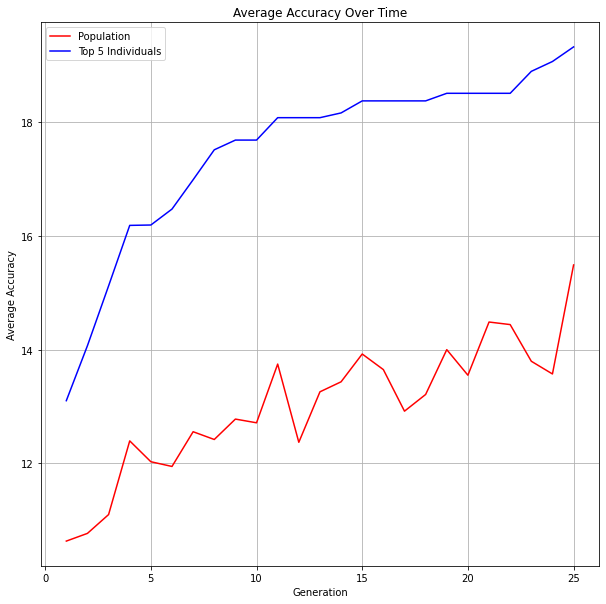

In [13]:
def main():
  start = time.time()
  clearOldData()
  raw = getRawData()
  data = preprocessData(raw)
  model = getFittestIndividual(data)
  predictions = predict(data[1][0], model)
  accuracy = evalResults(data[1], predictions)
  end = time.time()
  print('Classifier Accuracy: %f%%' % (accuracy * 100))
  print('Finished in %ds' % (end - start))
  graphFitness()

if __name__ == "__main__":
  main()


## Testing

In [ ]:
def uniformCrossover(parents):
  print('Performing uniform crossover...')
  newPopulation = list()

  # Parents get to survive to next generation
  newPopulation += parents

  # Performs uniform crossover for selected parents
  for i in range(SELECTION_SIZE, POPULATION_SIZE):
    # Select parents for new individual
    parentA, parentB = random.sample(parents, 2)

    # Construct new individual
    # Note that for this network, weights are [n x m] matrix
    # biases are list of size m
    individual = buildModel()
    for j in range(len(parentA.layers)):
      weights = np.zeros(parentA.layers[j].get_weights()[0].shape)
      weightsA = parentA.layers[j].get_weights()[0]
      weightsB = parentB.layers[j].get_weights()[0]
      for r in range(weights.shape[0]):
        for c in range(weights.shape[1]):
          weights[r][c] = (weightsA[r][c] if random.random() < 0.5 else weightsB[r][c])
          # Add random mutations
          if (random.random() < MUTATION_RATE):
            weights[r][c] = random.uniform(*MUTATION_WEIGHT_RANGE)
      
      biases = np.zeros(parentA.layers[j].get_weights()[1].shape)
      biasesA = parentA.layers[j].get_weights()[1]
      biasesB = parentB.layers[j].get_weights()[1]
      for k in range(biases.shape[0]):
        biases[k] = (biasesA[k] if random.random() < 0.5 else biasesB[k])
        # Add random mutations
        if (random.random() < MUTATION_RATE):
          biases[k] = random.uniform(*MUTATION_BIAS_RANGE)
      
      individual.layers[j].set_weights([weights, biases])
    newPopulation.append(individual)
    # Throw in possible mutations to genes
    # newPopulation.append(mutate(individual))
  
  return newPopulation